## Welcome!

This notebook will allow for the detection of modal filters and analysis of neighbourhood accessiablity within a single notebook. 

### General set up
Import libraries, set location etc.

In [1]:
place = "Newcastle Upon Tyne, United Kingdom"

In [2]:
### set up python
## Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import statistics
from shapely.ops import unary_union
import random

## Update settings
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\b8008458\AppData\Local\Temp\ipykernel_13880\935787008.py:23: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


In [3]:
### set up location boundary
# set location and get boundary
boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)

Now we get our streets from OpenStreetMap and OS

In [4]:
### get street nodes and edges for walking and driving from OpenStreetMap

## reset boundary_buffered crs for passing to OSM
boundary_buffered_4326 = boundary_buffered.to_crs('4326')

## get street networks
all_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='all', simplify=False)
walk_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='walk', simplify=True)
drive_streets = ox.graph_from_polygon(boundary_buffered_4326.geometry.iloc[0], network_type='drive', simplify=False)

all_edges = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)
all_nodes = ox.graph_to_gdfs(all_streets, nodes=True, edges=False)

walk_edges = ox.graph_to_gdfs(walk_streets, nodes=False, edges=True)
walk_nodes = ox.graph_to_gdfs(walk_streets, nodes=True, edges=False)

drive_edges = ox.graph_to_gdfs(drive_streets, nodes=False, edges=True)
drive_nodes = ox.graph_to_gdfs(drive_streets, nodes=True, edges=False)



## find the common nodes between networks
# this ensures that shortest paths between points should always be able to be calculated
common_nodes = drive_nodes.merge(walk_nodes, on='osmid', suffixes=('_drive', '_walk'))
common_nodes_gdf = gpd.GeoDataFrame(common_nodes, geometry='geometry_drive')



In [5]:
### read in roads
os_open_roads = gpd.read_file(r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\oproad_gpkg_gb\Data\oproad_roads_only.gpkg")

Create neighbourhood boundaries

In [6]:
### set up neighbourhoods
# set location and get boundary
boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)

## get railways
# for unknown reasons, using rail = ox.graph_from_place(place, custom_filter='["railway"]')
# doesn't ALWAYS retrive the full rail network, hence why multiple lines are used to achive the same result

# Get the major rail network
railway_types = ["","rail", "light_rail", "narrow_gauge", "subway", "tram"]

# set an empty
combined_railways = nx.MultiDiGraph()

for railway_type in railway_types:
    try:
        network = ox.graph_from_place(place, simplify=False 
                                      , custom_filter=f'["railway"~"{railway_type}"]'
                                      )
    
    # handle locations where not all rail types are found
    except Exception as e:
        print(f"No railway data found for '{railway_type}'.")
        network = nx.MultiGraph()

    combined_railways = nx.compose(combined_railways, network)
    


# convert to gdf
railways = ox.graph_to_gdfs(combined_railways, nodes=False, edges=True)




# Drop any other railway types that aren't needed
railways = railways.loc[(~railways["railway"].isin(["tunnel", "abandoned", "razed", "disused", "funicular", "monorail", "miniature"]))]

# set railways crs
railways = railways.to_crs('EPSG:27700')



## get rivers
# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')


tags = {"waterway": ["river", "rapids"]}

rivers = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# Dropping rows where 'tunnel' is equal to 'culvert'
if 'tunnel' in rivers.columns:
    # Dropping rows where 'tunnel' is equal to 'culvert'
    rivers = rivers[rivers['tunnel'] != 'culvert']

# set/reset crs
rivers = rivers.to_crs('27700')
boundary_buffered = boundary_buffered.to_crs('27700')


## get unsuitable landcover types
# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Define tags
tags = {"landuse": ["industrial", "railway", "brownfield", "commercial", "farmland", "meadow"]}

# Use ox.features_from_polygon to find features matching the specified tags
landuse = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
landuse = landuse.to_crs('27700')

## get unsuitable "nature" types

# Define tags
tags = {"natural": ["wood", "water", "scrub"]}

# Use ox.features_from_polygon to find features matching the specified tags
nature = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
nature = nature.to_crs('27700')

## get unsuitable "lesiure" types. This is mainly for golfcourses

# Define tags
tags = {"leisure": ["golf_course", "track", "park"]}

# Use ox.features_from_polygon to find features matching the specified tags
leisure = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
leisure = leisure.to_crs('27700')


## get unsuitable "areoway" types. This is mainly for airports

# Define tags
tags = {"aeroway": ["aerodrome"]}

# Use ox.features_from_polygon to find features matching the specified tags
aeroway = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
aeroway = aeroway.to_crs('27700')

boundary_buffered = boundary_buffered.to_crs('27700')

# concat
landuse = pd.concat([landuse, nature, leisure, aeroway])




## get bus routes from OSM/NAPTAN

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Calculate the bounding box for XML query
bounding_box = boundary_buffered.bounds

# Extract the minimum and maximum coordinates
minx = bounding_box['minx'].min()
miny = bounding_box['miny'].min()
maxx = bounding_box['maxx'].max()
maxy = bounding_box['maxy'].max()

# Create a list of four elements representing the bounding box
bbox = [minx, miny, maxx, maxy]

# reset boundary_buffer crs
boundary_buffered = boundary_buffered.to_crs('27700')

# Define the Overpass API endpoint
overpass_url = "https://overpass-api.de/api/interpreter"

# Define the XML query
xml_query = f"""
<osm-script output="json" output-config="" timeout="160">
  <union into="_">
    <query into="_" type="node">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="way">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="relation">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
  </union>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="body" n="" order="id" s="" w=""/>
  <recurse from="_" into="_" type="down"/>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="skeleton" n="" order="quadtile" s="" w=""/>
</osm-script>

"""
# Initialize lists to store data
geometries = []
element_data = []

# Make the Overpass API request
response = requests.post(overpass_url, data=xml_query)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Access the data from the response
    for element in data.get("elements", []):
        if element.get('type') == 'way' and 'geometry' in element:
            # Extract geometry coordinates from 'geometry' field
            coordinates = [(node['lon'], node['lat']) for node in element['geometry']]
            # Create a LineString geometry
            line = LineString(coordinates)
            geometries.append(line)
            element_data.append(element)

    # Create a GeoDataFrame
    bus_routes = gpd.GeoDataFrame(element_data, geometry=geometries)

    # Set CRS
    bus_routes = bus_routes.set_crs('4326')
    bus_routes = bus_routes.to_crs('27700')

else:
    print(f"Error fetching data: {response.status_code} - {response.text}")



## clip roads, rivers and railways to boundary

# clip
os_open_roads_clip = gpd.clip(os_open_roads, boundary_buffered)
rivers_clip = gpd.clip(rivers, boundary_buffered)
railways_clip = gpd.clip(railways, boundary_buffered)
landuse_clip = gpd.clip(landuse, boundary_buffered)
bus_routes_clip = gpd.clip(bus_routes, boundary_buffered)







## count bus routes per road and remove roads with greater than 1 bus route on them

# set a buffer distance to convert roads to polygons
buffer_distance = 0.2  # Adjust this value as needed. Set in meters

# Create a new GeoDataFrame with the buffered geometries
bus_routes_buffered = bus_routes_clip.copy()  # Copy the original GeoDataFrame
bus_routes_buffered['geometry'] = bus_routes_buffered['geometry'].buffer(buffer_distance)

# count the number of overlapping bus routes
def count_overlapping_features(gdf):
    # Create an empty column to store the count of overlapping features
    gdf['Bus_routes_count'] = 0

    # Iterate through each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Get the geometry of the current row
        geometry = row['geometry']
        
        # Use a spatial filter to find overlapping features
        overlaps = gdf[gdf['geometry'].intersects(geometry)]
        
        # Update the Bus_routes_count column with the count of overlapping features
        gdf.at[idx, 'Bus_routes_count'] = len(overlaps)
    
    return gdf

# call function
bus_routes_buffered_with_count = count_overlapping_features(bus_routes_buffered)

# drop any roads which have less than two bus routes on them

bus_routes_clip = bus_routes_buffered_with_count[bus_routes_buffered_with_count['Bus_routes_count'] >= 2]



# Find "boundary" roads
boundary_roads = os_open_roads_clip.loc[((os_open_roads_clip['primary_route'] == 'True') |
                        (os_open_roads_clip['trunk_road'] == 'True') |
                        (os_open_roads_clip['fictitious'] == 'True') |
                        (os_open_roads_clip['road_classification'] == 'A Road') | 
                        (os_open_roads_clip['road_classification'] == 'B Road') | 
                        #(os_open_roads_clip['road_function'] == 'Restricted Local Access Road') |
                        (os_open_roads_clip['road_function'] == 'Minor Road') |
                        (os_open_roads_clip['road_function'] == 'Motorway') |
                        (os_open_roads_clip['road_function'] == 'Minor Road')  
                        )]





## buffering and dissolving functions
 
def buffer_and_dissolve(input_gdf):
    # Buffer around boundaries
    buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

    # Dissolve the geometries
    dissolved_geo = buffered_gdf.unary_union

    # Create a new GeoDataFrame with the dissolved geometry
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

    # Set the CRS (Coordinate Reference System)
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf

def dissolve_gdf(input_gdf):
    # dissolve geometries
    dissolved_geo = input_gdf.unary_union
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf


## buffer and dissolve 
boundary_roads_bd = buffer_and_dissolve(boundary_roads)
boundary_rivers_bd = buffer_and_dissolve(rivers_clip)
boundary_rail_bd = buffer_and_dissolve(railways_clip)
boundary_landuse_bd = buffer_and_dissolve(landuse_clip)
boundary_bus_routes_bd = buffer_and_dissolve(bus_routes_clip)





## join all boundary features
boundaries = pd.concat([boundary_rivers_bd 
                        ,boundary_roads_bd 
                        ,boundary_rail_bd 
                        ,boundary_landuse_bd
                        ,boundary_bus_routes_bd
                        ], ignore_index=True)
boundary_features = dissolve_gdf(boundaries)
# Use the `difference` method to perform the "Erase" operation
erased_boundary = boundary.difference(boundary_features.unary_union)

# Convert the GeoSeries to a single geometry using unary_union
erased_boundary = erased_boundary.unary_union

# Create a new GeoDataFrame with the result of "Erase" operation
erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

# explode multipolygon to polygons
erased_boundary_gdf = erased_boundary_gdf.explode()

neighbourhoods = erased_boundary_gdf


## drop very small areas (such as the centre of roundabouts etc)
# calculate area
neighbourhoods["area"] = neighbourhoods.geometry.area
# Drop rows where area is less than 5000. This value is arbitary
neighbourhoods = neighbourhoods.loc[neighbourhoods["area"] >= 10000]
neighbourhoods.explore()


## drop areas with no roads
def count_roads_within_polygons(polygons_gdf, roads_gdf, polygon_column_name):
    """
    Count the number of roads within each polygon in a GeoDataFrame.
    
    Args:
        polygons_gdf (GeoDataFrame): GeoDataFrame containing polygons.
        roads_gdf (GeoDataFrame): GeoDataFrame containing roads.
        polygon_column_name (str): Name of the column in polygons_gdf to use for grouping.

    Returns:
        GeoDataFrame: Original polygons GeoDataFrame with a "road_count" column added.
    """
    
    # spatial join
    joined = gpd.sjoin(polygons_gdf, roads_gdf, how='left', op='intersects')
    
    # Group by the polygon column and count the number of roads in each
    road_counts = joined.groupby(polygon_column_name).size().reset_index(name='road_count')
    
    # Merge the road counts back into the polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(road_counts, on=polygon_column_name, how='left')

     # Calculate road density (area divided by road_count). It is mulitiplied by 10000 for ease of understanding the numbers involved with this
    polygons_gdf['road_density'] = (polygons_gdf['road_count'] / polygons_gdf['area'] ) * 10000
    
    return polygons_gdf

neighbourhoods = count_roads_within_polygons(neighbourhoods, os_open_roads_clip, 'geometry')

# Drop rows with road_density below 0.2 or less than 4 roads
neighbourhoods = neighbourhoods[(neighbourhoods['road_count'] > 2)]
neighbourhoods = neighbourhoods[(neighbourhoods['road_density'] > 0.2)]
## create unique IDs

# simple number based ID
neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)

## remove holes from neighbourhoods (for visual reasons mostly)
# Function to remove holes from neighbourhoods
def remove_holes(polygon):
    if polygon.geom_type == 'Polygon':
        return Polygon(polygon.exterior)
    else:
        return polygon

# Apply the function to the 'geometry' column of the GeoDataFrame
neighbourhoods['geometry'] = neighbourhoods['geometry'].apply(remove_holes)

## filter neighbourhoods to only locations with more than 1 intersection (1 or fewer intersections indicates that all travel modes will be the same)
# reset neighbourhoods crs
neighbourhoods = neighbourhoods.to_crs('4326')

# Spatial join to count points within each neighborhood
spatial_join = gpd.sjoin(neighbourhoods, common_nodes_gdf, how='left', op='contains')

# Group by 'ID' and count the points within each neighborhood
point_counts = spatial_join.groupby('ID').size().reset_index(name='point_count')

# Filter out neighborhoods with 1 or 0 points
filtered_neighbourhood_ids = point_counts[point_counts['point_count'] > 1]['ID']

neighbourhoods= neighbourhoods[neighbourhoods['ID'].isin(filtered_neighbourhood_ids)]





No railway data found for 'narrow_gauge'.
No railway data found for 'subway'.
No railway data found for 'tram'.


C:\Users\b8008458\AppData\Local\Temp\ipykernel_13880\4170148980.py:324: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
### check neighbourhoods look good
neighbourhoods.explore()

Generate access metrics

In [8]:
### find accessiablity

## all to all
def calculate_distance_stats_from_points(points_gdf, network):
    all_pairs_shortest_paths = {}
    points_osmids = points_gdf.index.tolist()  # Assuming the 'osmid' is the index in the GeoDataFrame

    for start_node in points_osmids:
        shortest_paths = {}
        try:
            for end_node in points_osmids:
                if start_node != end_node:
                    distance = nx.shortest_path_length(network, start_node, end_node, weight='length')
                    shortest_paths[end_node] = distance
            all_pairs_shortest_paths[start_node] = shortest_paths
        except nx.NetworkXNoPath:
            # If no path is found, skip adding to all_pairs_shortest_paths
            continue

    distances = [length for paths in all_pairs_shortest_paths.values() for length in paths.values()]

    mean_distance = statistics.mean(distances)
    median_distance = statistics.median(distances)
    min_distance = min(distances)
    max_distance = max(distances)
    distance_range = max_distance - min_distance
    total_distance = sum(distances)

    return {
        "mean_distance": mean_distance,
        "median_distance": median_distance,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "distance_range": distance_range,
        "total_distance": total_distance
    }

## processing for all to all 
results = []

for index, row in neighbourhoods.iterrows():
    neighbourhood = neighbourhoods.loc[[index]]
    print("Starting index number", index)

    ## get neighbourhood boundary and neighbourhood boundary buffer
    # set crs
    neighbourhood = neighbourhood.to_crs('27700')
    # create a buffer neighbourhood
    neighbourhood_buffer = neighbourhood['geometry'].buffer(15)
    # convert back to a geodataframe (for later on)
    neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)
    # reset crs
    neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


    ## get nodes which can be driven to and walked to within area
    neighbourhood_nodes = gpd.clip(common_nodes_gdf, neighbourhood_buffer)

    ## get length of total edges within the neighbourhood
    edges_within_neighbourhood = gpd.sjoin(all_edges, neighbourhood, how="inner", op="intersects")
    total_length = edges_within_neighbourhood['length'].sum()


    ## calculate neighbourhood distance stats for walking and driving
    walk_stats = calculate_distance_stats_from_points(neighbourhood_nodes, walk_streets)
    drive_stats = calculate_distance_stats_from_points(neighbourhood_nodes, drive_streets)


    ## Add the statistics to the GeoDataFrame
    neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
    neighbourhood['walk_median_distance'] = walk_stats['median_distance']
    neighbourhood['walk_min_distance'] = walk_stats['min_distance']
    neighbourhood['walk_max_distance'] = walk_stats['max_distance']
    neighbourhood['walk_distance_range'] = walk_stats['distance_range']
    neighbourhood['walk_total_distance'] = walk_stats['total_distance']

    neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
    neighbourhood['drive_median_distance'] = drive_stats['median_distance']
    neighbourhood['drive_min_distance'] = drive_stats['min_distance']
    neighbourhood['drive_max_distance'] = drive_stats['max_distance']
    neighbourhood['drive_distance_range'] = drive_stats['distance_range']
    neighbourhood['drive_total_distance'] = drive_stats['total_distance']

    ## Store statistics along with neighborhood ID or other identifying information
    result = {
        'neighbourhood_id': neighbourhood['ID'].iloc[0],  # Assuming you have an ID column
        'walk_mean_distance': walk_stats['mean_distance'],
        'walk_median_distance': walk_stats['median_distance'],
        'walk_total_distance': walk_stats['total_distance'],
        

        'drive_mean_distance': drive_stats['mean_distance'],
        'drive_median_distance': drive_stats['median_distance'],
        'drive_total_distance': drive_stats['total_distance'],

        'total_edge_length': total_length
    }
    results.append(result)

## Convert the results to a new dataframe
results_df = pd.DataFrame(results)


## calculate differances

results_df['mean_distance_diff'] = results_df['walk_mean_distance'] - results_df['drive_mean_distance']
results_df['median_distance_diff'] = results_df['walk_median_distance'] - results_df['drive_median_distance']
results_df['total_distance_diff'] = results_df['walk_total_distance'] - results_df['drive_total_distance']

merged_df = pd.merge(neighbourhoods, results_df, left_on = "ID", right_on = "neighbourhood_id")
access_results_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')


Starting index number 2


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 3


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 4


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 5


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 6
Starting index number 7


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 8
Starting index number 9


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 10


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 11


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 12


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 13
Starting index number 15


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 16


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 17


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 27


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 28


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 29


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 31


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 32


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 33


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 34


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 35


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 36


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 42


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 45


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 46


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 47


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 48


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 49


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 50


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 51


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 54


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 55


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 65


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 66


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 67


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 68


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 69


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 70


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 72


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 73


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 74


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 75


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 76


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 77


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 78


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 79


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 80


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 83


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 84


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 85


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 88


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 90


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 97


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 98


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 99


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 100
Starting index number 101


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 102


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 103


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 104


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 105


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 107


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 108


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 109


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 110


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 111


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 114


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 115


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 117


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 118


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 119


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 120


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 121


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 122


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 123


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 124


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 125


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 126


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 128


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 129


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 130


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 131


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 132


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 133


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 134


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 135


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 136


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 137


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 138


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 139


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 149
Starting index number 151


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 152


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 153


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 154


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 155


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 156


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 157


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 158


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 159


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 160


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 162


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 163


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 164


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 167


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 168


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 169


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 170


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 171


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 172


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 173


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 174


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 176


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 179


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 180


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 187


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 190


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 191


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 192


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 193


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 194


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 197


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 198


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 200


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 201


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 202


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 204


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 205


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 206


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 207


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 209
Starting index number 212


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 217


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 219


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 222


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 223


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 224


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 226


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 227


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 228


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 229


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 230


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 231


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 232


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 234


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 236


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 237


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 239


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 240


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 244


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 245


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 246


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 247


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 248


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 249


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 251


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 252


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 253


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 256
Starting index number 257


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 258


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 261


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 263


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 264


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 265


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 268


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 269


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 270


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 271


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 272


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 273


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 274


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 275


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 276


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 277


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 278


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 280


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 282


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 283


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 284


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 285


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 286


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 287


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 288


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 289


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 290


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 291


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 292


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 293


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 294


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 295


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 296


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 297


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 299


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 300


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 301


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 302


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 303
Starting index number 304


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 305
Starting index number 306


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 308


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 309


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 311


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 312


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 313


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 315
Starting index number 316


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 317


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Starting index number 318


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Find modal filters

In [9]:
### find modal filters


## get barrier filters
# get the boundary in the correct CRS for OSMnx
boundary_4326 = boundary.to_crs('EPSG:4326')

# get the most "basic" filters mapped, the barriers/bollards etc
# get barrier filters
# Define tags
tags = {"barrier": ["bollard", "bus_trap", "entrance", "planter", "sump_buster", "wedge"]}

# Use ox.features_from_polygon to find features matching the specified tags
barriers = ox.features_from_polygon(polygon = boundary_4326.geometry.iloc[0], tags = tags)


## process any linestrings into point geometries

# Filter the GeoDataFrame to select only rows with "linestring" geometry
barriers_linestrings = barriers[barriers['geometry'].geom_type == 'LineString']

# Create an empty GeoDataFrame to store the individual points
points_gdf = gpd.GeoDataFrame(columns=list(barriers_linestrings.columns), crs=barriers_linestrings.crs)

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Create a GeoDataFrame from the individual points and copy the attributes
        points_df = gpd.GeoDataFrame(geometry=points, crs=barriers_linestrings.crs)
        for col in barriers_linestrings.columns:
            if col != 'geometry':
                points_df[col] = row[col]
        
        # Rename the "geometry" column to "merged_geometry"
        points_df = points_df.rename(columns={'geometry': 'merged_geometry'})
        
        # Append the points to the points_gdf
        points_gdf = pd.concat([points_gdf, points_df], ignore_index=True)

# Now, points_gdf contains all the individual points from the linestrings with inherited attributes

# Remove the "geometry" column from the points GeoDataFrame
points_gdf = points_gdf.drop(columns=['geometry'])

# Remove the linestring rows from the original GeoDataFrame
barriers = barriers[barriers['geometry'].geom_type != 'LineString']

# Rename the "merged_geometry" column to "geometry" in the points GeoDataFrame
points_gdf = points_gdf.rename(columns={'merged_geometry': 'geometry'})

# Concatenate the individual points GeoDataFrame to the original GeoDataFrame
barriers = pd.concat([barriers, points_gdf], ignore_index=True)

# Reset the index to ensure it is continuous
barriers.reset_index(drop=True, inplace=True)

# Create a new column "previously_linestring" and set it to False initially
barriers['previously_linestring'] = False

# Iterate through each row in the GeoDataFrame with linestrings
for idx, row in barriers_linestrings.iterrows():
    if isinstance(row['geometry'], LineString):
        # Extract the individual points from the linestring
        points = [Point(coord) for coord in list(row['geometry'].coords)]
        
        # Iterate through the points in the linestring
        for point in points:
            # Check if the point's geometry intersects with any of the original linestrings
            mask = barriers['geometry'].intersects(point)
            if mask.any():
                # If the point intersects with any linestring, set "previously_linestring" to True
                barriers.loc[mask, 'previously_linestring'] = True

# add a unique ID
barriers['barrier_id'] = range(1, len(barriers) + 1)

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_gdf = ox.graph_to_gdfs(all_streets, nodes=False, edges=True)

# join the barriers to the streets 
streets_gdf = gpd.sjoin(streets_gdf, barriers, how = "left", op="intersects")

# clean geodataframe and drop streets without a barrier
streets_gdf.columns = streets_gdf.columns.str.replace("_right", "_barrier").str.replace("_left","_street")
# we need to double check the name of "barrier"
streets_gdf['barrier_barrier'] = streets_gdf['barrier'] if 'barrier' in streets_gdf.columns else streets_gdf['barrier_barrier']

if 'name_street' in streets_gdf.columns:
    streets_gdf = streets_gdf.rename(columns={'name_street': 'name'})
barrier_streets = streets_gdf.dropna(subset=['barrier_barrier'])

# add barrier tag
barrier_streets['filter_type'] = 'barrier or bollard'


## extract points which are on/within 1m of streets only
streets_gdf['has_barrier'] = 'yes'

# reset crs before spatail join
barriers, streets_gdf = barriers.to_crs(3857), streets_gdf.to_crs(3857)

barriers = gpd.sjoin_nearest(barriers, streets_gdf, how = "left", max_distance = 1)
barriers = barriers.dropna(subset=['has_barrier'])
barriers = barriers.reset_index(drop=True)  # Reset the index
# Dissolve based on the 'geometry' column

# re-reset crs 
barriers, streets_gdf = barriers.to_crs(4326), streets_gdf.to_crs(4326)

# we need to double check the name of "barrier_id"
import numpy as np
streets_gdf['barrier_id_right'] = streets_gdf['barrier_id'] if 'barrier_id' in streets_gdf.columns else streets_gdf['barrier_id_right']
# dissolve
barriers = barriers.dissolve(by='barrier_id_right')
# add barrier tag
barriers['filter_type'] = 'barrier or bollard'
# Reset the index to remove multi-index
barriers.reset_index(drop=True, inplace=True)





## bus gates also act as modal filters. lets now find all the bus gates within our streets

# we need to double check the name of "access"
streets_gdf['access_street'] = streets_gdf['access'] if 'access' in streets_gdf.columns else streets_gdf['access_street']
streets_gdf['bicycle_street'] = streets_gdf['bicycle'] if 'bicycle' in streets_gdf.columns else streets_gdf['bicycle_street']
streets_gdf['bus'] = streets_gdf['bus_street'] if 'bus_street' in streets_gdf.columns else streets_gdf['bus']


busgates = streets_gdf[((streets_gdf["bus"] == "yes") & (streets_gdf["access_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")) |
                    (streets_gdf["bus"] == "yes") & (streets_gdf["motor_vehicle_street"] == "no") & (streets_gdf["bicycle_street"] == "yes")
                    ]

# add bus gate tag
busgates['filter_type'] = 'bus gate'






## one-way streets also can act as modal filters. lets find where cycling is unrestricted but cars are
oneways = streets_gdf[(streets_gdf["oneway"] == True) & (streets_gdf["oneway:bicycle"] == "no")]

# we dissolve the roads with the same name as to not miscount the total number of oneways
# Convert values in the "name" column to strings if they are not already
oneways['name'] = oneways['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# Perform dissolve 
oneways = oneways.dissolve(by='name')

# Reset the index 
oneways = oneways.reset_index()



# add one way tag
oneways['filter_type'] = 'one-way bike'



def filter_streets_continuations(input_gdf):
    ## clean dataframe
    # Check if 'highway_street' column exists and rename it to 'highway'
    if 'highway_street' in input_gdf.columns:
        input_gdf.rename(columns={'highway_street': 'highway'}, inplace=True)




    # filter dataframe 
    ## remove indoor roads, these are likey pedestrian only however often don't have any "cycling" related tag
    if 'covered' in input_gdf.columns:
        input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'covered' in str(x))]
        input_gdf = input_gdf[input_gdf['covered'] != 'yes']
    ## also remove footways and steps, as these are almost pedestrain only, never cyclable
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'footway' in str(x))]
    input_gdf = input_gdf[~input_gdf['highway'].apply(lambda x: 'steps' in str(x))]



    ## clean dataframe
    input_gdf['name'] = input_gdf['name'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
    input_gdf['highway'] = input_gdf['highway'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))




    ## perform street continunation filtering
    # Grouping by 'name' and checking for groups with 'pedestrian' and another highway type
    grouped = input_gdf.groupby('name').filter(lambda x: any('pedestrian' in val for val in x['highway']) and len(x['highway'].unique()) > 1)
    street_continuations_gdf = grouped[grouped['highway'].str.contains('pedestrian', case=False, na=False)] # Extracting the rows containing 'pedestrian' in the highway column

    ## deal with nan names


    ## dissolve lines that are very very close to each other
    if not street_continuations_gdf.empty:
        street_continuations_gdf = street_continuations_gdf.to_crs('27700')
        street_continuations_gdf['buffer'] = street_continuations_gdf.geometry.buffer(1)
        dissolved = street_continuations_gdf.dissolve(by='name')
        
        # If a MultiPolygon is formed, convert it to individual polygons
        if isinstance(dissolved.geometry.iloc[0], MultiPolygon):
            dissolved = dissolved.explode()
        
        # Remove the buffer column
        dissolved = dissolved.drop(columns='buffer')
        street_continuations_gdf = dissolved.to_crs('4326')

    return street_continuations_gdf


# get street continunations
streets_continuations_gdf = filter_streets_continuations(streets_gdf)

# add street conitinuation tag
streets_continuations_gdf['filter_type'] = 'street continuation'


filters = gpd.GeoDataFrame(pd.concat([barriers, busgates, oneways, streets_continuations_gdf], ignore_index=True))




## alter neighbourhoods before joining
# reset neighbourhood crs
filters_results_gdf  = neighbourhoods.to_crs('EPSG:27700')



# buffer to ensure all filters are captured
filters_results_gdf['geometry'] = filters_results_gdf['geometry'].buffer(5)

# reset neighbourhood crs
filters_results_gdf  = filters_results_gdf.to_crs('EPSG:4326')

## spatial join
# Perform a spatial join between neighbourhoods and filters
joined_data = gpd.sjoin(filters_results_gdf, filters, how="left", predicate="intersects")

# Count the number of each filter within each neighbourhood
filter_type_counts = joined_data.groupby(['ID', 'filter_type']).size().unstack(fill_value=0)

# Reset the index to make it more readable
filter_type_counts = filter_type_counts.reset_index()

# Merge the filter_type_counts DataFrame with the neighbourhoods GeoDataFrame on the ID column
filters_results_gdf = filters_results_gdf.merge(filter_type_counts, on='ID', how='left')

# find the total counts of each filter type per neighborhood
filters_results_gdf['total_filter_types'] = filters_results_gdf.iloc[:, 5:].sum(axis=1)

# Fill NaN values with 0 if necessary
filters_results_gdf = filters_results_gdf.fillna(0)




c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

Done :)

In [10]:
## now we should have filters_results_gdf and access_results_gdf

filters_results_gdf, access_results_gdf

(                                              geometry           area  \
 0    POLYGON ((-1.75440 54.98435, -1.75439 54.98435...   99554.969514   
 1    POLYGON ((-1.76572 54.98392, -1.76572 54.98392...   15780.402803   
 2    POLYGON ((-1.74800 54.98491, -1.74800 54.98491...   80559.276741   
 3    POLYGON ((-1.74485 54.98827, -1.74484 54.98827...  216467.550042   
 4    POLYGON ((-1.73719 54.98699, -1.73719 54.98700...   63955.786410   
 ..                                                 ...            ...   
 207  POLYGON ((-1.57612 54.98580, -1.57660 54.98579...   74320.705834   
 208  POLYGON ((-1.54669 54.99059, -1.54669 54.99059...   37507.537107   
 209  POLYGON ((-1.56256 54.99119, -1.56256 54.99119...  312894.086514   
 210  POLYGON ((-1.57866 54.99098, -1.57866 54.99098...  474108.566670   
 211  POLYGON ((-1.57203 55.00465, -1.57205 55.00475...  622287.145264   
 
      road_count  road_density   ID  barrier or bollard  one-way bike  \
 0             6      0.602682    1  

## Testing from this point onwards:

In [61]:
results_gdf = gpd.GeoDataFrame(filters_results_gdf.merge(access_results_gdf, on="ID", suffixes=('_filters', "_access")))
results_gdf = results_gdf.set_geometry('geometry_access')

In [62]:
results_gdf['drive_walk_ratio'] = results_gdf['drive_total_distance'] / results_gdf['walk_total_distance'] 
results_gdf['walk_drive_ratio'] = results_gdf['walk_total_distance'] / results_gdf['drive_total_distance'] 

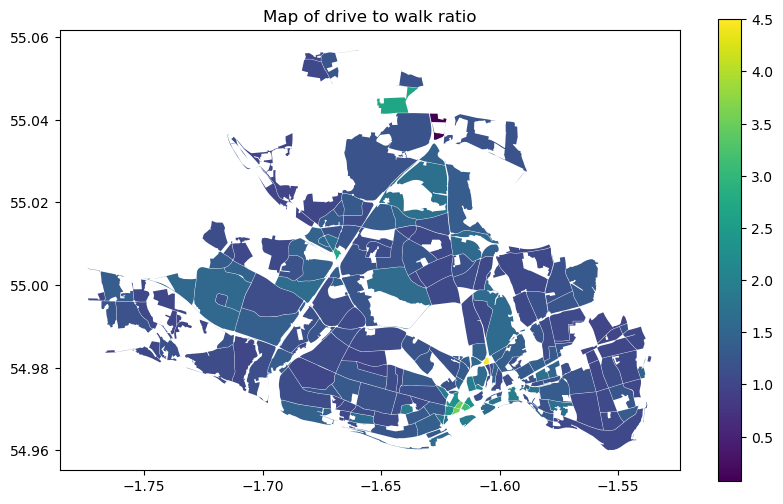

In [63]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='drive_walk_ratio', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Map of drive to walk ratio')
plt.show()

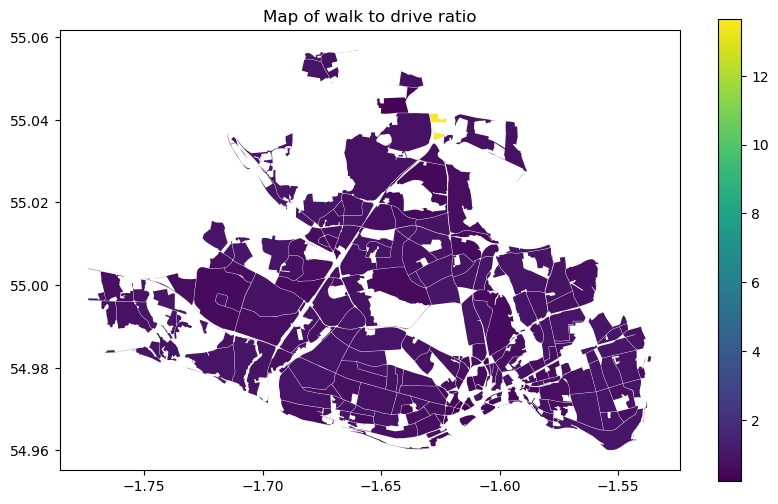

In [64]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='walk_drive_ratio', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Map of walk to drive ratio')
plt.show()

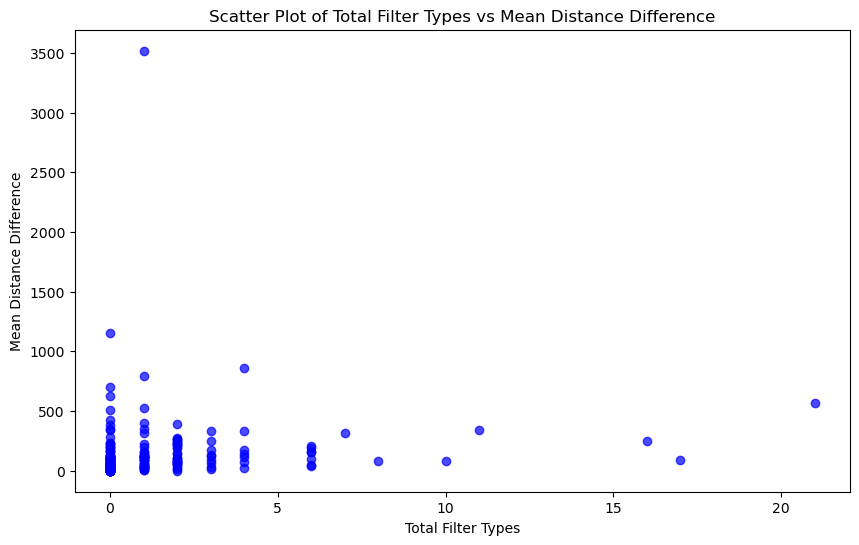

In [65]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(results_gdf["total_filter_types"], results_gdf["mean_distance_diff"].abs(), c='blue', alpha=0.7)
plt.xlabel('Total Filter Types')
plt.ylabel('Mean Distance Difference')
plt.title('Scatter Plot of Total Filter Types vs Mean Distance Difference')
plt.show()

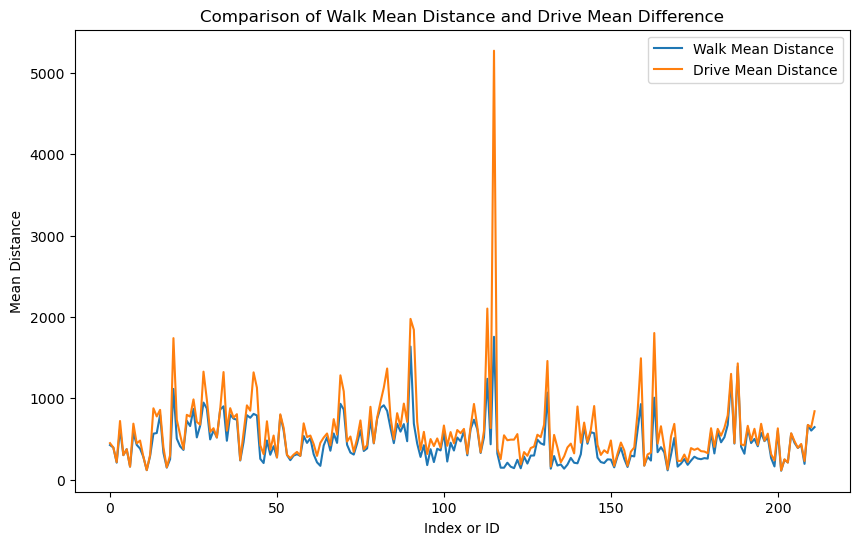

In [66]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_gdf["walk_mean_distance"], label='Walk Mean Distance')
plt.plot(results_gdf["drive_mean_distance"], label='Drive Mean Distance')
plt.xlabel('Index or ID')  # You can change this label as per your data
plt.ylabel('Mean Distance')
plt.title('Comparison of Walk Mean Distance and Drive Mean Difference')
plt.legend()
plt.show()


c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\matplotlib\text.py:757: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posx = float(self.convert_xunits(self._x))
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\matplotlib\text.py:897: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(self._x))


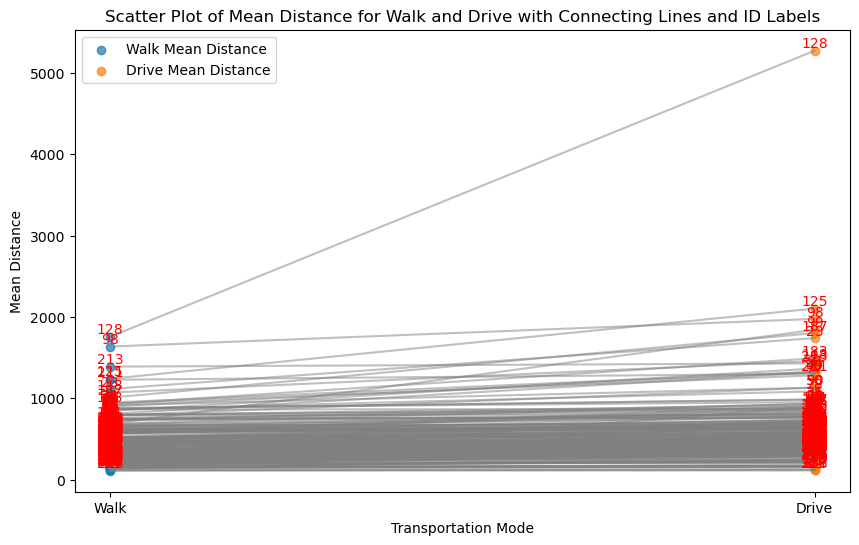

In [67]:
import matplotlib.pyplot as plt

# Assuming you have a GeoDataFrame named results_gdf
# with columns "walk_mean_distance" and "drive_mean_distance"

# Creating a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(['Walk']*len(results_gdf), results_gdf["walk_mean_distance"], label='Walk Mean Distance', alpha=0.7)
plt.scatter(['Drive']*len(results_gdf), results_gdf["drive_mean_distance"], label='Drive Mean Distance', alpha=0.7)

# Drawing lines between matching IDs or indexes
for i in range(len(results_gdf)):
    plt.plot(['Walk', 'Drive'], [results_gdf.iloc[i]["walk_mean_distance"], results_gdf.iloc[i]["drive_mean_distance"]], c='gray', alpha=0.5)
    plt.text('Walk', results_gdf.iloc[i]["walk_mean_distance"], results_gdf.iloc[i]["ID"], ha='center', va='bottom', color='red')
    plt.text('Drive', results_gdf.iloc[i]["drive_mean_distance"], results_gdf.iloc[i]["ID"], ha='center', va='bottom', color='red')

plt.xlabel('Transportation Mode')
plt.ylabel('Mean Distance')
plt.title('Scatter Plot of Mean Distance for Walk and Drive with Connecting Lines and ID Labels')
plt.legend()
plt.show()


In [68]:
from scipy.stats import pearsonr

# Assuming you have a GeoDataFrame named results_gdf
# with columns "total_filter_types" and "mean_distance_diff"

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(results_gdf["total_filter_types"], results_gdf["mean_distance_diff"])

print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")


Pearson correlation coefficient: -0.11157840726522908
P-value: 0.10521857971622302


In [69]:
from scipy.stats import spearmanr

# Assuming you have a GeoDataFrame named results_gdf
# with columns "total_filter_types" and "mean_distance_diff"

# Calculate Spearman's rank correlation coefficient and p-value
spearman_coefficient, p_value_spearman = spearmanr(results_gdf["total_filter_types"], results_gdf["mean_distance_diff"])

print(f"Spearman's rank correlation coefficient: {spearman_coefficient}")
print(f"P-value (Spearman): {p_value_spearman}")


Spearman's rank correlation coefficient: -0.3476093343502705
P-value (Spearman): 2.0556253578851412e-07


In [ ]:
import momepy
 

primal = momepy.closeness_centrality(all_streets, radius=300, name='closeness400', distance='length', weight='length')

nodes = momepy.nx_to_gdf(primal, lines=False)

# Manually normalize the closeness centrality values in the GeoDataFrame
max_closeness = nodes['closeness400'].max()
nodes['normalized_closeness'] = nodes['closeness400'] / max_closeness

# plot
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()

In [ ]:
all_streets_cc = momepy.closeness_centrality(all_streets, radius=400, name='closeness400', distance='length', weight='length')

all_streets_nodes_cc = momepy.nx_to_gdf(all_streets_cc, lines=False)

# Manually normalize the closeness centrality values in the GeoDataFrame
max_closeness = all_streets_nodes_cc['closeness400'].max()
all_streets_nodes_cc['normalized_closeness'] = all_streets_nodes_cc['closeness400'] / max_closeness


f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='closeness400', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400')
plt.show()

100%|██████████| 23110/23110 [01:09<00:00, 334.27it/s]
C:\Users\b8008458\AppData\Local\Temp\ipykernel_13880\1527954992.py:3: UserWarning: Approach is not set. Defaulting to 'primal'.
  walk_streets_nodes_cc = momepy.nx_to_gdf(walk_streets_cc, lines=False)


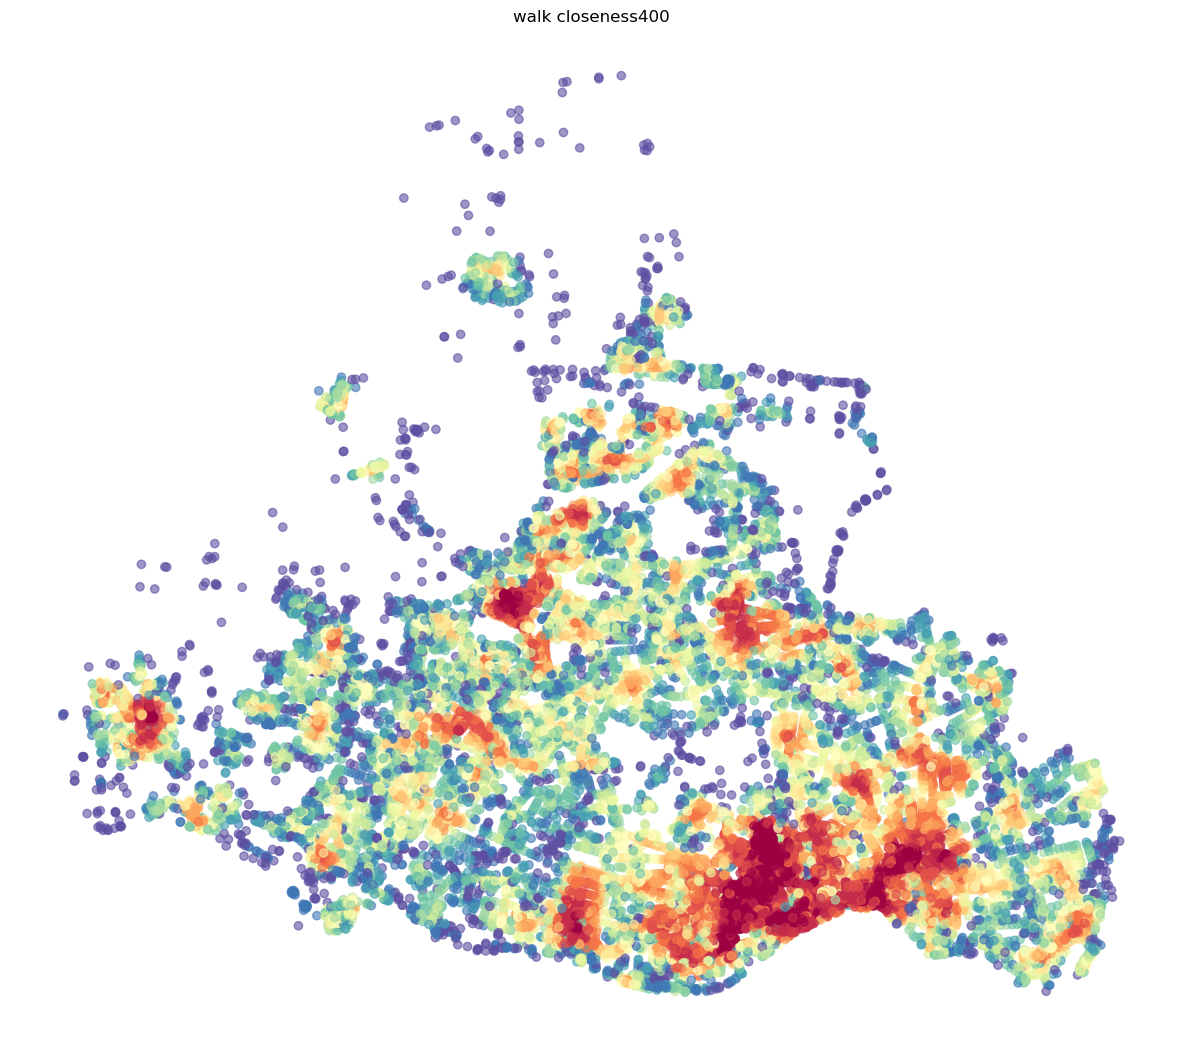

In [33]:
walk_streets_cc = momepy.closeness_centrality(walk_streets, radius=400, name='walk_closeness400', distance='length', weight='length')

walk_streets_nodes_cc = momepy.nx_to_gdf(walk_streets_cc, lines=False)

# Manually normalize the closeness centrality values in the GeoDataFrame
max_closeness = walk_streets_nodes_cc['walk_closeness400'].max()
walk_streets_nodes_cc['walk_normalised_closeness'] = walk_streets_nodes_cc['walk_closeness400'] / max_closeness


f, ax = plt.subplots(figsize=(15, 15))
walk_streets_nodes_cc.plot(ax=ax, column='walk_normalised_closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('walk closeness400')
plt.show()

100%|██████████| 36090/36090 [01:33<00:00, 384.42it/s]
C:\Users\b8008458\AppData\Local\Temp\ipykernel_13880\3577421690.py:3: UserWarning: Approach is not set. Defaulting to 'primal'.
  drive_streets_nodes_cc = momepy.nx_to_gdf(drive_streets_cc, lines=False)


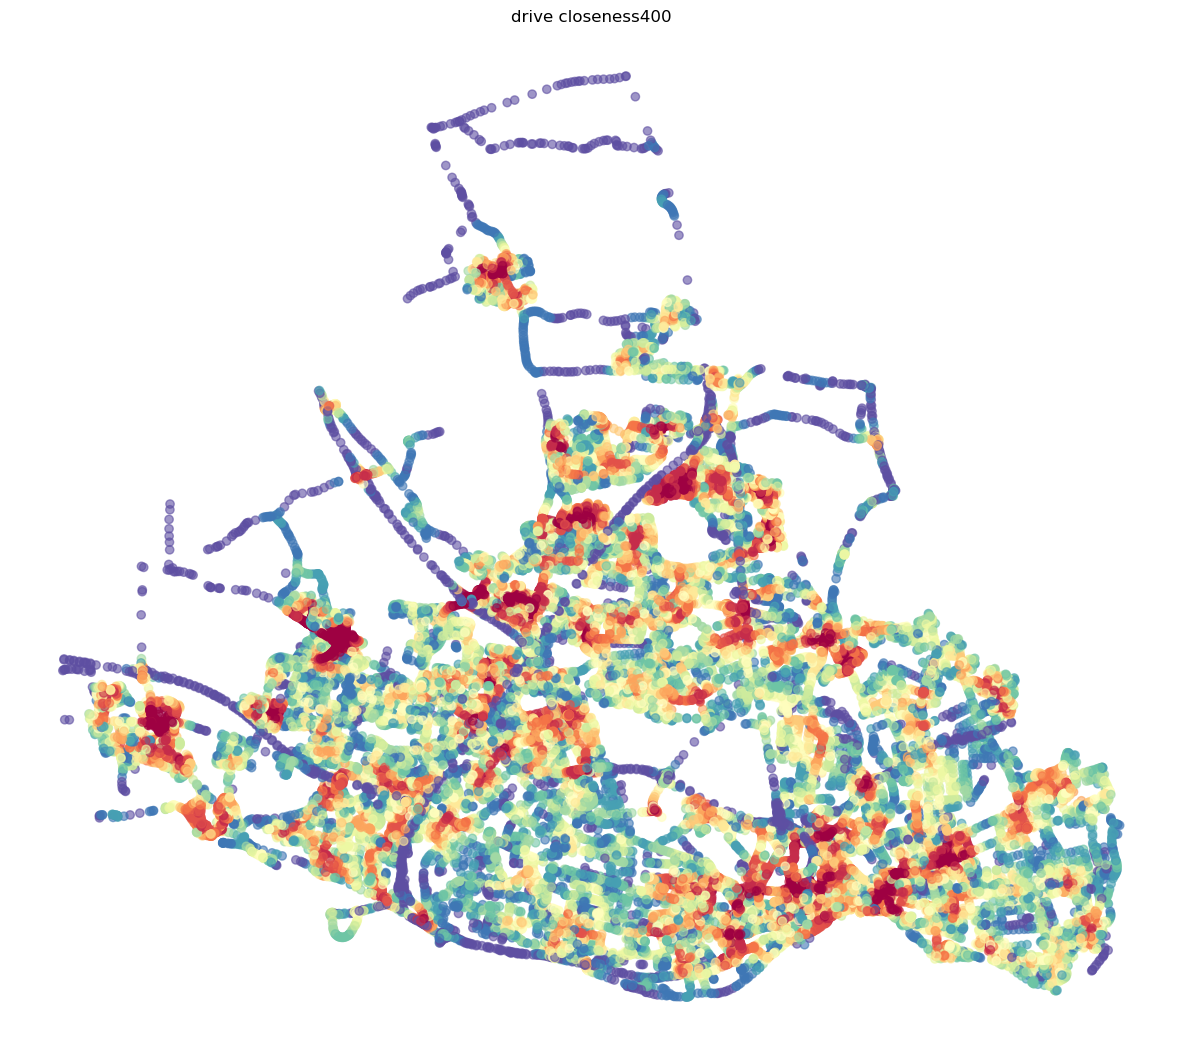

In [34]:
drive_streets_cc = momepy.closeness_centrality(drive_streets, radius=400, name='drive_closeness400', distance='length', weight='length')

drive_streets_nodes_cc = momepy.nx_to_gdf(drive_streets_cc, lines=False)

# Manually normalize the closeness centrality values in the GeoDataFrame
max_closeness = drive_streets_nodes_cc['drive_closeness400'].max()
drive_streets_nodes_cc['drive_normalised_closeness'] = drive_streets_nodes_cc['drive_closeness400'] / max_closeness


f, ax = plt.subplots(figsize=(15, 15))
drive_streets_nodes_cc.plot(ax=ax, column='drive_normalised_closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('drive closeness400')
plt.show()

In [70]:
## join closness centrailty measures

## walk 

# Spatial join to associate each point with its corresponding polygon
joined_data = gpd.sjoin(walk_streets_nodes_cc, results_gdf, how='right', op='within')

# Group by polygon ID and calculate the mean and max of walk_closeness400
grouped_data = joined_data.groupby('ID')['walk_closeness400'].agg(mean='mean', max_value='max').reset_index()

# Merge the results back into the results_gdf
results_gdf = results_gdf.merge(grouped_data, how='left', on='ID')

# Rename the new columns
results_gdf.rename(columns={'mean': 'walk_node_cc_average_mean',
                            'max_value': 'walk_node_cc_max'}, inplace=True)

## drive

# Spatial join to associate each point with its corresponding polygon
joined_data = gpd.sjoin(drive_streets_nodes_cc, results_gdf, how='right', op='within')

# Group by polygon ID and calculate the mean and max of drive_closeness400
grouped_data = joined_data.groupby('ID')['drive_closeness400'].agg(mean='mean', max_value='max').reset_index()

# Merge the results back into the results_gdf
results_gdf = results_gdf.merge(grouped_data, how='left', on='ID')

# Rename the new columns
results_gdf.rename(columns={'mean': 'drive_node_cc_average_mean',
                            'max_value': 'drive_node_cc_max'}, inplace=True)



c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


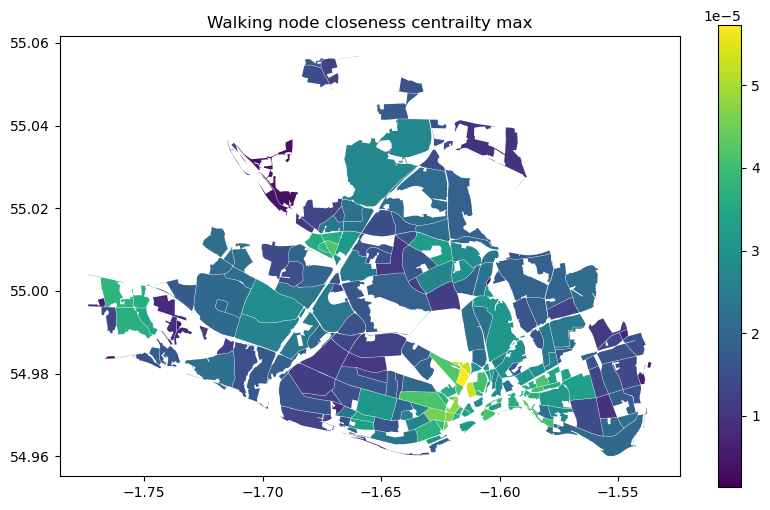

In [77]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='walk_node_cc_max', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Walking node closeness centrailty max')
plt.show()

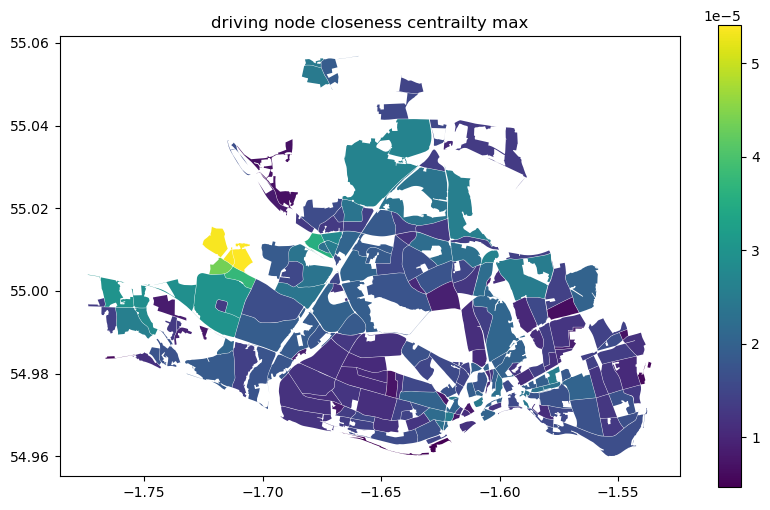

In [78]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='drive_node_cc_max', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('driving node closeness centrailty max')
plt.show()

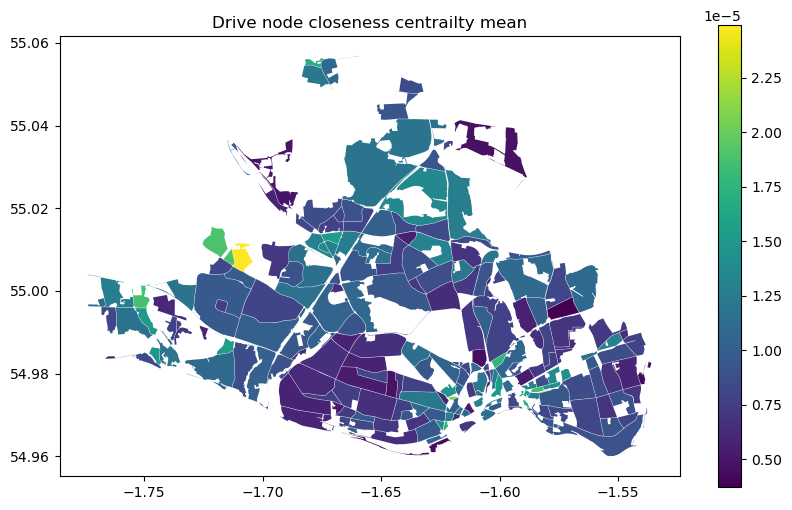

In [79]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='drive_node_cc_average_mean', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Drive node closeness centrailty mean')
plt.show()

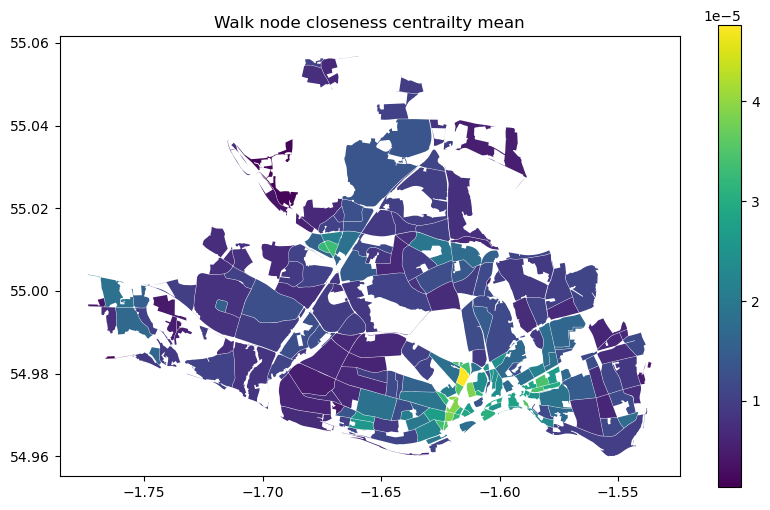

In [80]:
# Plotting the map based on "node_cc_average"
results_gdf.plot(column='walk_node_cc_average_mean', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Walk node closeness centrailty mean')
plt.show()

Betweenness centrailty

In [81]:
# calcualte bc
walk_edge_bc = nx.edge_betweenness_centrality(walk_streets, normalized = True, weight = 'length')
########################################### need to dropp some roads first???
drive_edge_bc = nx.edge_betweenness_centrality(drive_streets, normalized = True, weight = 'length')

In [120]:
# convert to geodataframes
walk_streets_gdf = ox.graph_to_gdfs(walk_streets, nodes=False, edges=True)
drive_streets_gdf = ox.graph_to_gdfs(drive_streets, nodes=False, edges=True)

In [121]:

# Convert edge betweenness dictionary to DataFrames
walk_edge_bc_df = pd.DataFrame(list(walk_edge_bc.items()), columns=['edge', 'walk_edge_betweenness'])
drive_edge_bc_df = pd.DataFrame(list(drive_edge_bc.items()), columns=['edge', 'drive_edge_betweenness'])

# Extract u and v columns from the edge column for walk_streets_gdf
walk_edge_bc_df[['u', 'v', 'key']] = pd.DataFrame(walk_edge_bc_df['edge'].tolist(), index=walk_edge_bc_df.index)

# Extract u and v columns from the edge column for drive_streets_gdf
drive_edge_bc_df[['u', 'v', 'key']] = pd.DataFrame(drive_edge_bc_df['edge'].tolist(), index=drive_edge_bc_df.index)

# Merge the edge betweenness DataFrames with walk_streets_gdf and drive_streets_gdf
walk_streets_gdf = pd.merge(walk_streets_gdf, walk_edge_bc_df[['u', 'v', 'walk_edge_betweenness']], how='left', on=['u', 'v'])
drive_streets_gdf = pd.merge(drive_streets_gdf, drive_edge_bc_df[['u', 'v', 'drive_edge_betweenness']], how='left', on=['u', 'v'])

# Perform a spatial join based on geometry to associate edges with polygons for walk_streets_gdf
joined_data_walk = gpd.sjoin(walk_streets_gdf, results_gdf, how='right', op='within')

# Group by the polygon ID and calculate the mean and max of walk_edge_betweenness
grouped_data_walk = joined_data_walk.groupby('ID')['walk_edge_betweenness'].agg(walk_bc_mean='mean', walk_bc_max='max').reset_index()

# Merge the results back into results_gdf
results = pd.merge(results_gdf, grouped_data_walk, how='left', on='ID')

# Perform a spatial join based on geometry to associate edges with polygons for drive_streets_gdf
joined_data_drive = gpd.sjoin(drive_streets_gdf, results_gdf, how='right', op='within')

# Group by the polygon ID and calculate the mean and max of drive_edge_betweenness
grouped_data_drive = joined_data_drive.groupby('ID')['drive_edge_betweenness'].agg(drive_bc_mean='mean', drive_bc_max='max').reset_index()

# Merge the results back into results_gdf
results = pd.merge(results, grouped_data_drive, how='left', on='ID')

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [125]:
results.explore()